<a href="https://colab.research.google.com/github/Stegi56/Face-Covering-Detection/blob/main/Face_Covering_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Set up torch

In [1]:
import torch #ref Lab 9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Load Google drive and get files

In [2]:
import os
os.environ["OPENCV_ENABLE_NONFREE"] = "1"
from google.colab import drive

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Face Covering Detection'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/drive
['CV2024_CW_Dataset.zip', 'CV2024_CW_Dataset', 'Report template.docx', 'Coursework UG - Sit.pdf', 'Marking scheme.pdf', 'Coursework UG - Sit.gdoc', 'Face Covering Detection.ipynb']


Load Zip File (Ref Lab 9)

In [3]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

## Load images and labels

I am using downsampling and upsampling since the majority class is significantly greater and I fear duplication on this scale would risk overfitting.

Ref Lab 6


In [203]:
from skimage import io
from skimage.transform import resize
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from PIL import Image

def crop_and_resize(img, target_shape=(128, 128)): #ref https://cloudinary.com/guides/bulk-image-resize/python-image-resize-with-pillow-and-opencv
    im = Image.fromarray(img)
    # Center-crop to square
    min_side = min(im.size)
    left = (im.width - min_side) // 2
    top = (im.height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    im_cropped = im.crop((left, top, right, bottom))
    # Resize to target shape
    im_resized = im_cropped.resize(target_shape, Image.BILINEAR)
    return np.array(im_resized)

def import_selected_data(type):
  images = []
  labels = []

  for image in os.listdir(os.path.join(type, "images")):
    img = io.imread(os.path.join(type, "images", image))
    img_resized = crop_and_resize(img)

    images.append(img_resized)
    match open(
      os.path.join(type, "labels", image.split(".")[0] + ".txt"),
      "r"
      ).read():
      case "0":
        label = "no mask"
      case "1":
        label = "good mask"
      case "2":
        label = "bad mask"

    labels.append(label)

  return images, labels

X_train, y_train = [], []
X_train_balanced, y_train_balanced = [], []
X_test, y_test = [], []
X_validation, y_validation = [], []

def loadDataImbalanced():
  global X_train, y_train, X_test, y_test

  X, y = import_selected_data("train")

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, shuffle=True, stratify=y)


def makeDataBalanced():
  global X_train_balanced, y_train_balanced, X_test, y_test, X_validation, y_validation
  loadDataImbalanced()

  X_train_indexes = np.arange(len(X_train)).reshape(-1, 1) # convert images to indexes for sampling

  undersample_strategy = {"good mask": 200, "no mask":200} #undersample good masks
  rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=56)


  oversample_strategy = {"bad mask": 200} # oversample bad and no mask
  ros = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=56)

  pipeline = Pipeline([("undersample", rus), ("oversample", ros)]) #combine samplers

  # Resample indices
  X_balanced_indexes, y_train_balanced = pipeline.fit_resample(
      X_train_indexes, y_train
  )

  indices = X_balanced_indexes.ravel()
  X_train_balanced = [X_train[i] for i in indices] #rebuild images using generated indexes

makeDataBalanced()

print("\nBalanced training data:")
print(Counter(y_train_balanced))

print("\nTest data:")
print(Counter(y_test))

X_validation, y_validation = import_selected_data("test")
print("\nValidation data:")
print(Counter(y_validation))


Balanced training data:
Counter({'bad mask': 200, 'good mask': 200, 'no mask': 200})

Test data:
Counter({'good mask': 388, 'no mask': 75, 'bad mask': 16})

Validation data:
Counter({'good mask': 388, 'no mask': 51, 'bad mask': 19})


# SIFT + SVM

## Get points of interest

Ref Lab 6

In [114]:
import cv2
from skimage import img_as_ubyte, color
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics


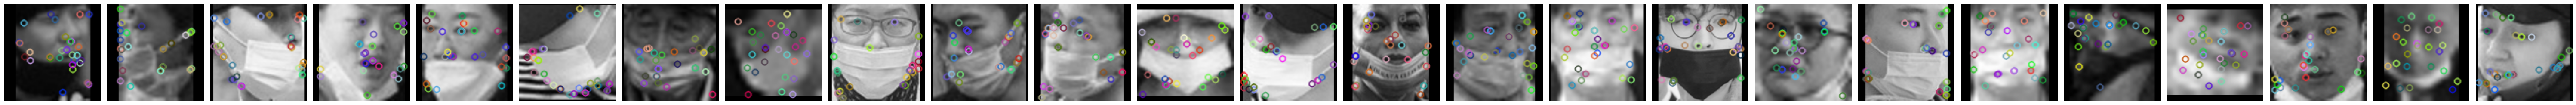

In [117]:
loadData()

sift = cv2.SIFT_create(
    nfeatures=30,
    nOctaveLayers=15,
    contrastThreshold=0.01,
    edgeThreshold=10,
    sigma=1.000001
)

des_list = []
y_train_list = []


fig, ax = plt.subplots(1, 25, figsize=(60, 60))

for i in range(len(X_train_balanced)):
    img = img_as_ubyte(color.rgb2gray(X_train_balanced[i]))
    kp, des = sift.detectAndCompute(img, None)

    if i<25:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train_balanced[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)


Clustering descriptors & Generate histograms of codewords Ref Lab 6



In [118]:
k = len(np.unique(y_train)) * 15

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0]
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

## Train SVM

In [120]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(C=1.0, kernel='rbf', gamma=0.1)

# We learn the digits on the first half of the digits
classifier.fit(hist_array, y_train_list)

SVC(gamma=0.1)

## Analysis SIFT + SVM

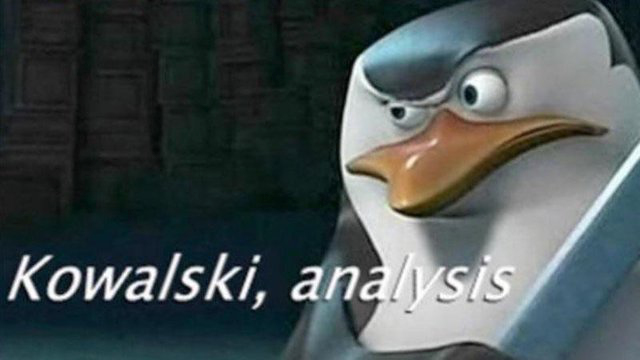

ref penguins of madagascar


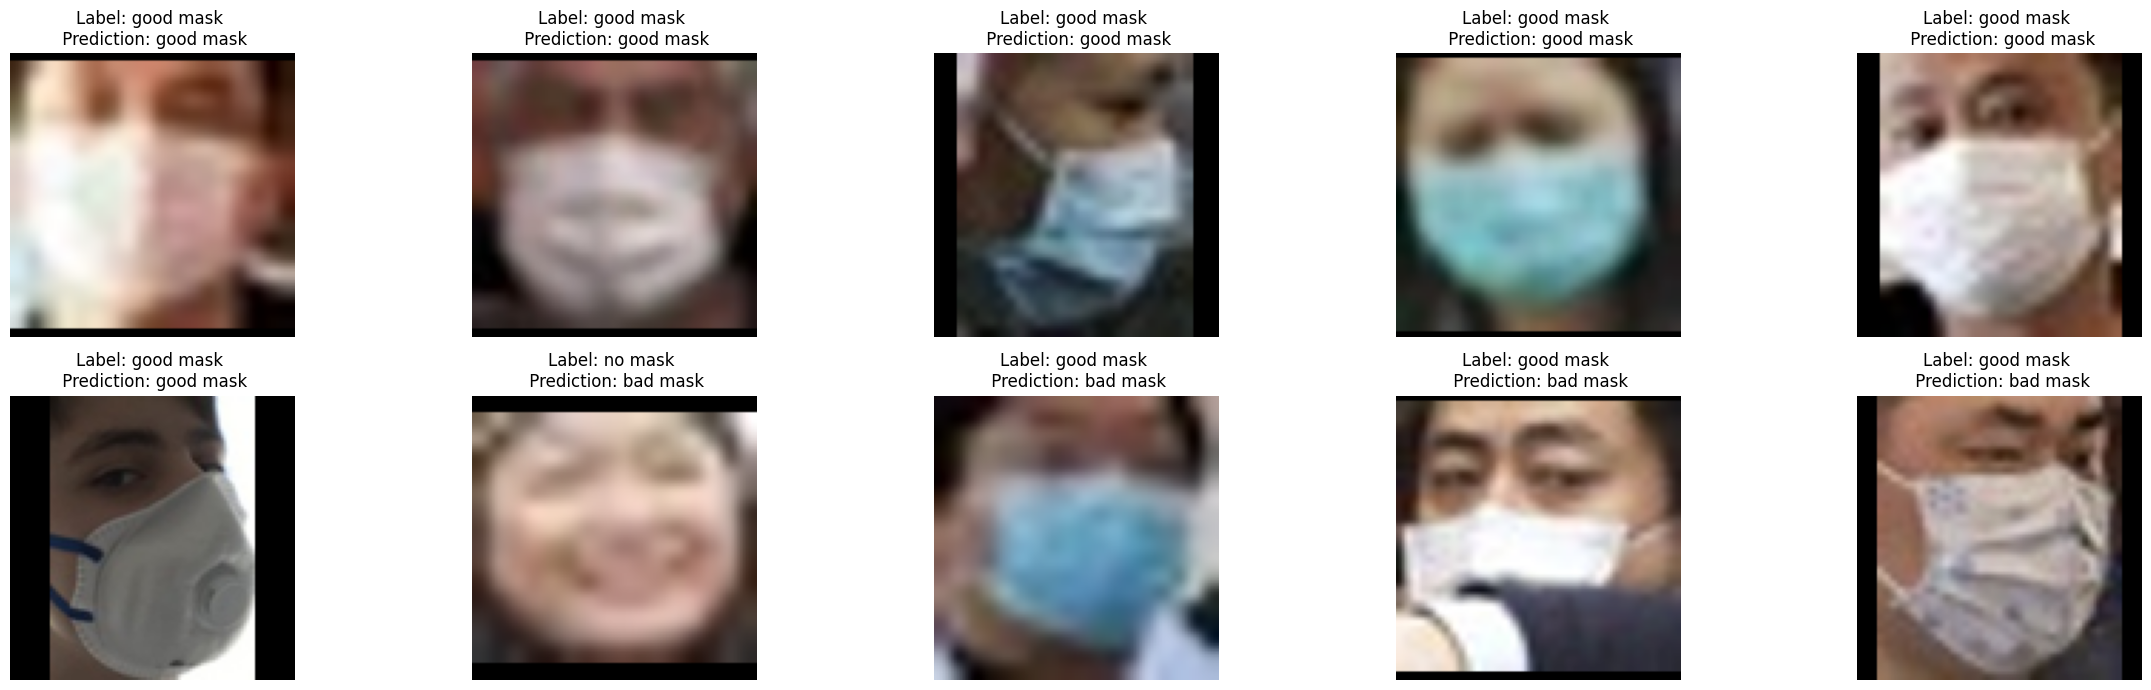

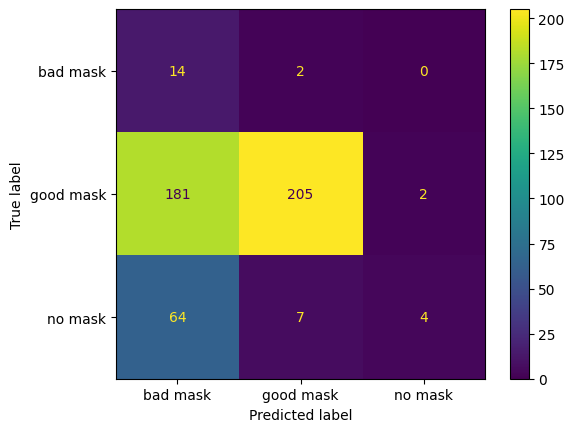

Classification report for classifier SVC(gamma=0.1):
                    precision    recall  f1-score   support

    bad mask       0.05      0.88      0.10        16
   good mask       0.96      0.53      0.68       388
     no mask       0.67      0.05      0.10        75

    accuracy                           0.47       479
   macro avg       0.56      0.49      0.29       479
weighted avg       0.88      0.47      0.57       479




In [121]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

y_pred = classifier.predict(hist_array).tolist()

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

## Final analysis SIFT + SVM

use validation set


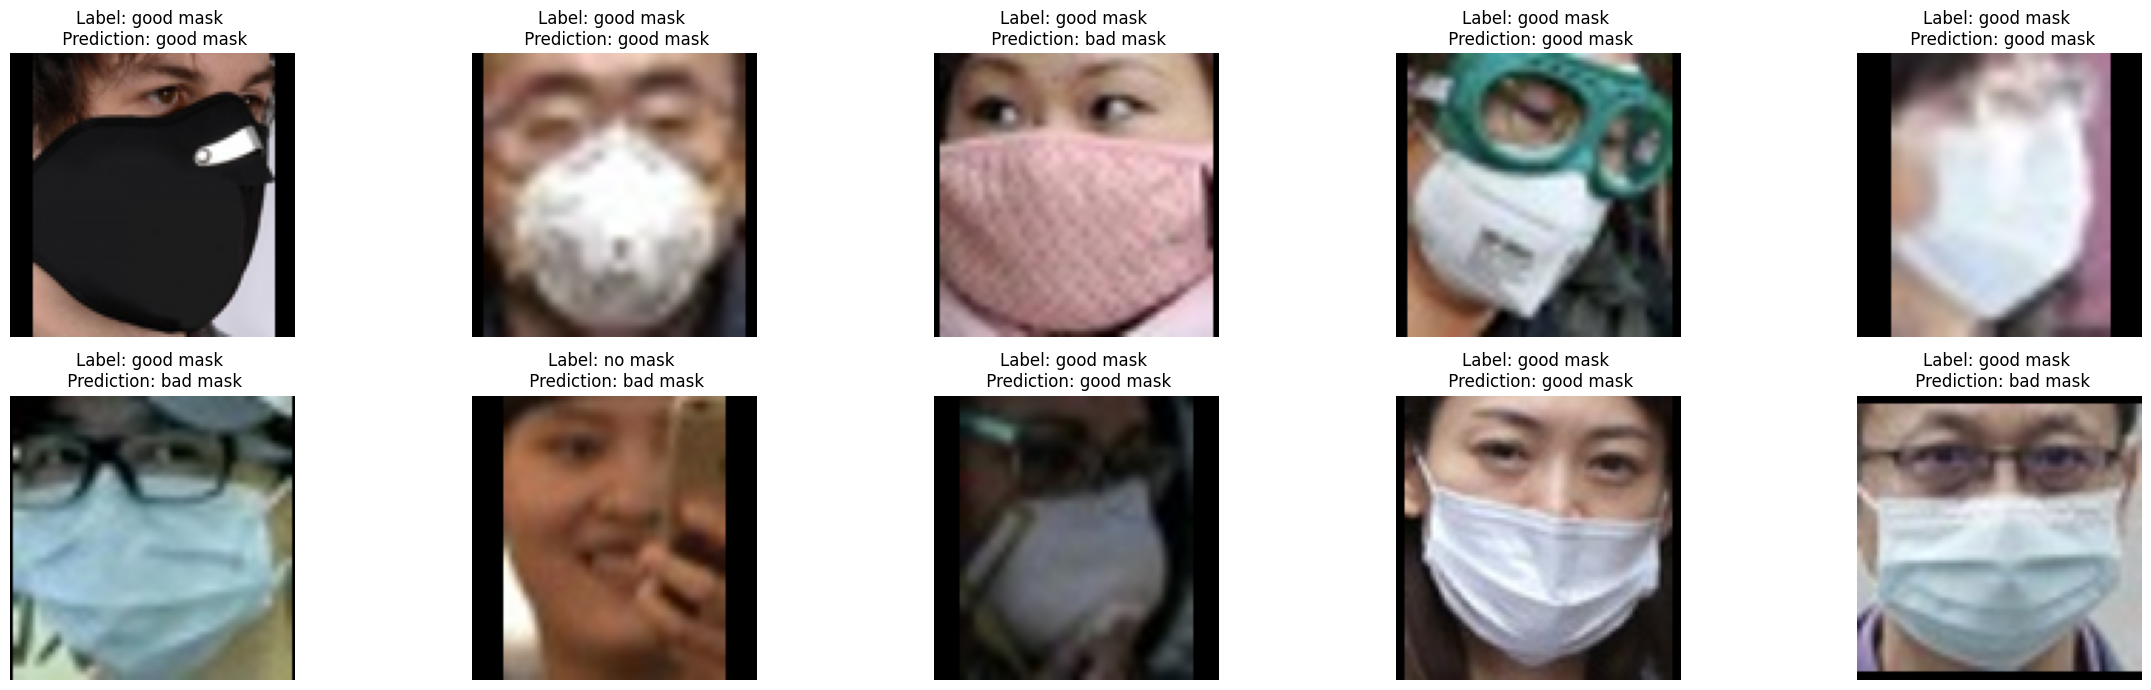

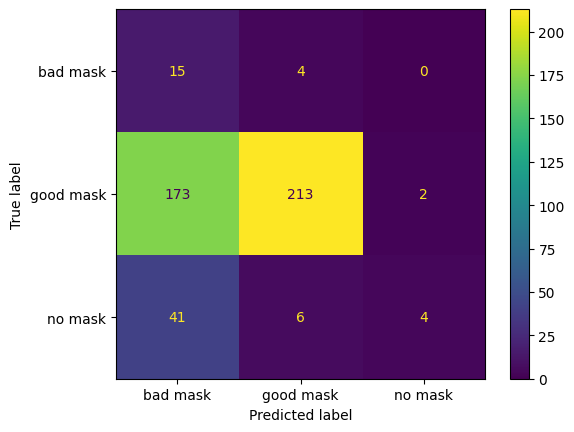

Classification report for classifier SVC(gamma=0.1):
                    precision    recall  f1-score   support

    bad mask       0.07      0.79      0.12        19
   good mask       0.96      0.55      0.70       388
     no mask       0.67      0.08      0.14        51

    accuracy                           0.51       458
   macro avg       0.56      0.47      0.32       458
weighted avg       0.89      0.51      0.61       458




In [122]:
hist_list = []

loadData()

for i in range(len(X_validation)):
    img = img_as_ubyte(color.rgb2gray(X_validation[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_validation = [y_validation[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

y_pred = classifier.predict(hist_array).tolist()

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_validation[i])
    ax[i].set_title(f'Label: {y_validation[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_validation, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_validation, y_pred)}\n""")

Ngl kowalski sift + SVM is pretty trash

# HOG + SVM

ref lab 5 & 6

In [177]:
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import GridSearchCV

## Extract HOG descriptors

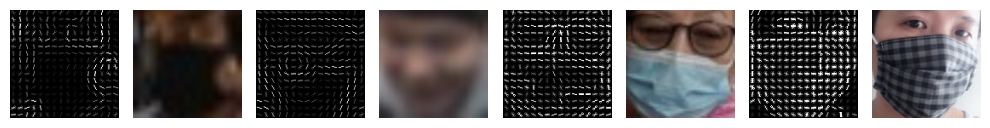

In [204]:
loadDataImbalanced()

fig, ax = plt.subplots(1, 16, figsize=(10, 8))

des_list = []
y_train_list = []

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    HOG_des, HOG_image = hog(X_train[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    # Show results for first 4 images
    if i<8:
      HOG_image_rescaled = exposure.rescale_intensity(HOG_image, in_range=(0, 10))

      ax[(i*2) + 1].set_axis_off()
      ax[(i*2) + 1].imshow(X_train[i])

      ax[(i*2)].set_axis_off()
      ax[(i*2)].imshow(HOG_image_rescaled, cmap='gray')

    des_list.append(HOG_des)
    y_train_list.append(y_train[i])


fig.tight_layout()
plt.show()

hist_array = np.vstack(des_list)

## Train SVM

In [206]:
# Create a classifier: a support vector classifier
svc = svm.SVC(kernel='linear', class_weight='balanced')
params = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}
classifier = GridSearchCV(svc, params, cv=5) #ref https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
classifier.fit(hist_array, y_train)

print("Best C:", classifier.best_params_['C'])
print("Best score:", classifier.best_score_)

Best C: 0.05
Best score: 0.8684073107049608


## Analysis HOG + SVM

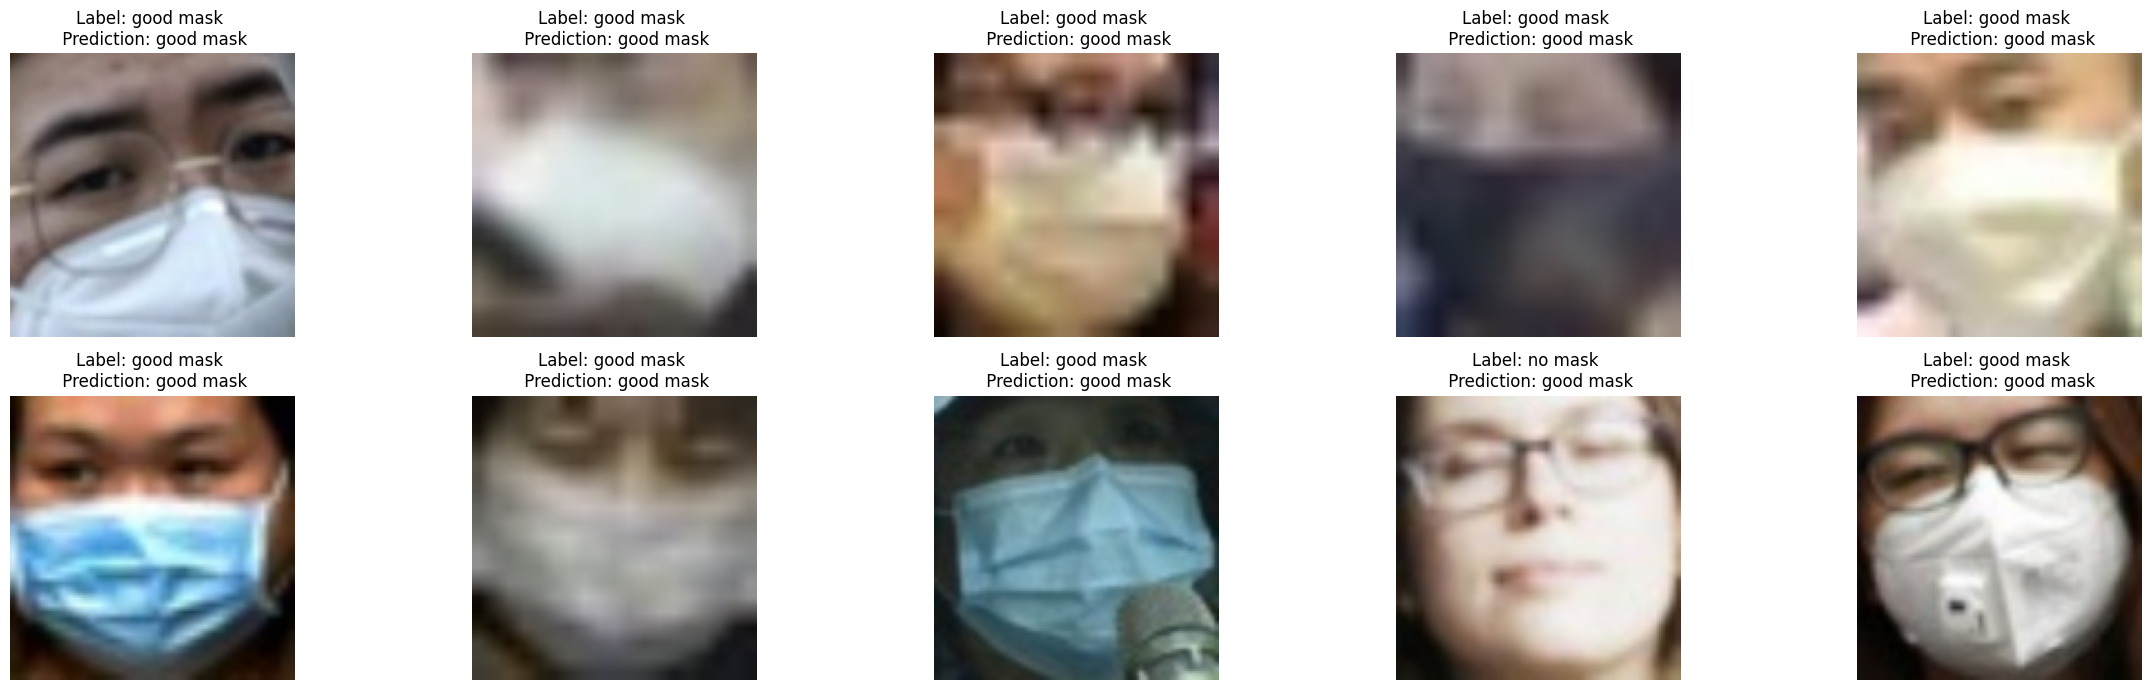

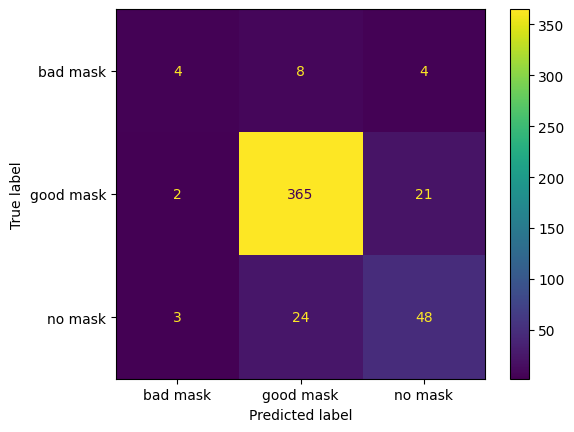

Classification report for classifier GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', kernel='linear'),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}):
                    precision    recall  f1-score   support

    bad mask       0.44      0.25      0.32        16
   good mask       0.92      0.94      0.93       388
     no mask       0.66      0.64      0.65        75

    accuracy                           0.87       479
   macro avg       0.67      0.61      0.63       479
weighted avg       0.86      0.87      0.87       479




In [207]:
des_list = []

for i in range(len(X_test)):
    # Identify keypoints and extract descriptors with SIFT
    HOG_des, HOG_image = hog(X_test[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    des_list.append(HOG_des)

hist_array = np.vstack(des_list)

y_pred = classifier.predict(hist_array).tolist()

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

## Final analysis HOG + SVM

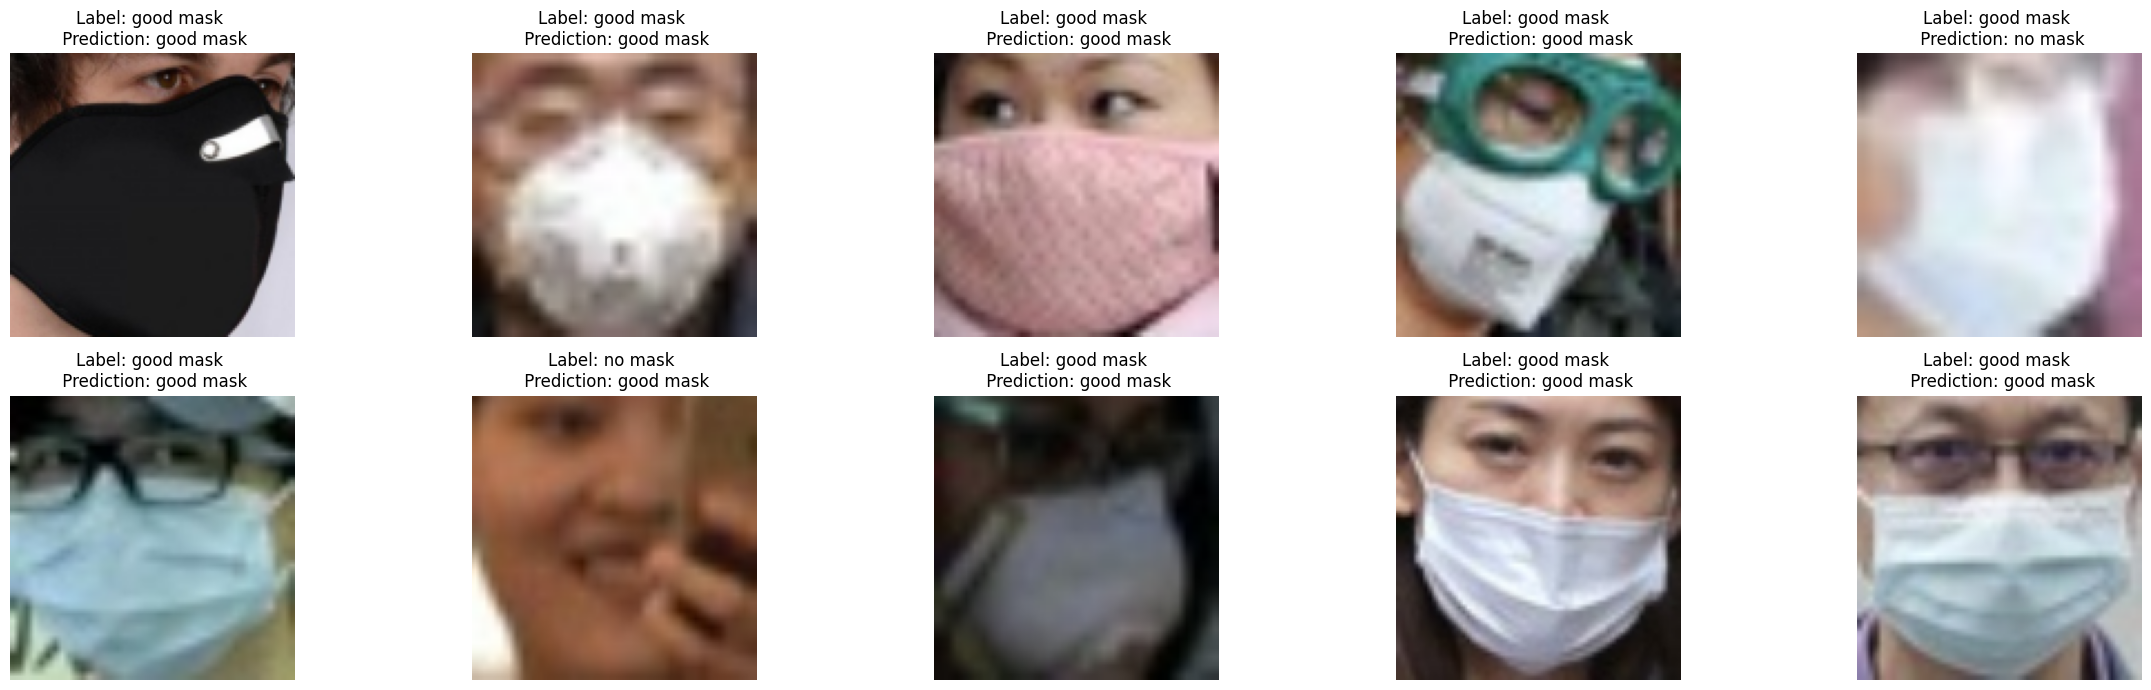

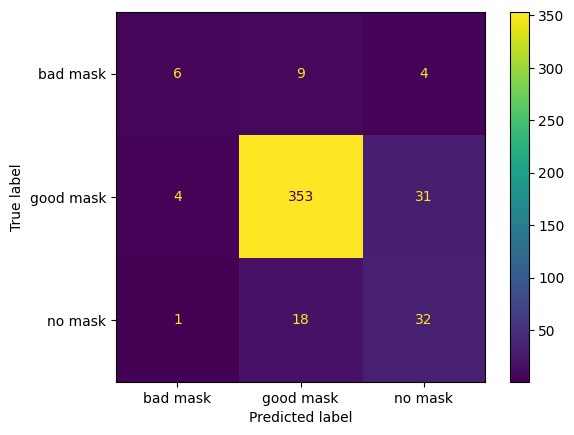

Classification report for classifier GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', kernel='linear'),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}):
                    precision    recall  f1-score   support

    bad mask       0.55      0.32      0.40        19
   good mask       0.93      0.91      0.92       388
     no mask       0.48      0.63      0.54        51

    accuracy                           0.85       458
   macro avg       0.65      0.62      0.62       458
weighted avg       0.86      0.85      0.86       458




In [208]:
des_list = []

for i in range(len(X_validation)):
    # Identify keypoints and extract descriptors with SIFT
    HOG_des, HOG_image = hog(X_validation[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    des_list.append(HOG_des)

hist_array = np.vstack(des_list)

y_pred = classifier.predict(hist_array).tolist()

fig, axes = plt.subplots(2, 5, figsize=(24, 7))
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_validation[i])
    ax[i].set_title(f'Label: {y_validation[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(y_validation, y_pred)
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_validation, y_pred)}\n""")